In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes
from pygimli.physics.ert import createERTData, ERTModelling

## Modèle

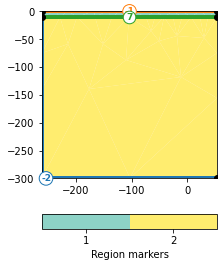

In [22]:
left = mt.createWorld(start=[-261.5, -300], end=[54, 0], layers=[-11])
for b in left.boundaries():
    if b.center().x() == 54:
        b.setMarker(0)

pg.viewer.showMesh(left, markers=True, showBoundary=True);

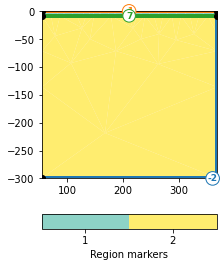

In [23]:
right = mt.createWorld(start=[54, -300], end=[368, 0], layers=[-8])
for b in right.boundaries():
    if b.center().x() == 54:
        b.setMarker(0)

pg.viewer.showMesh(right, markers=True, showBoundary=True);

Mesh: Nodes: 10 Cells: 0 Boundaries: 14

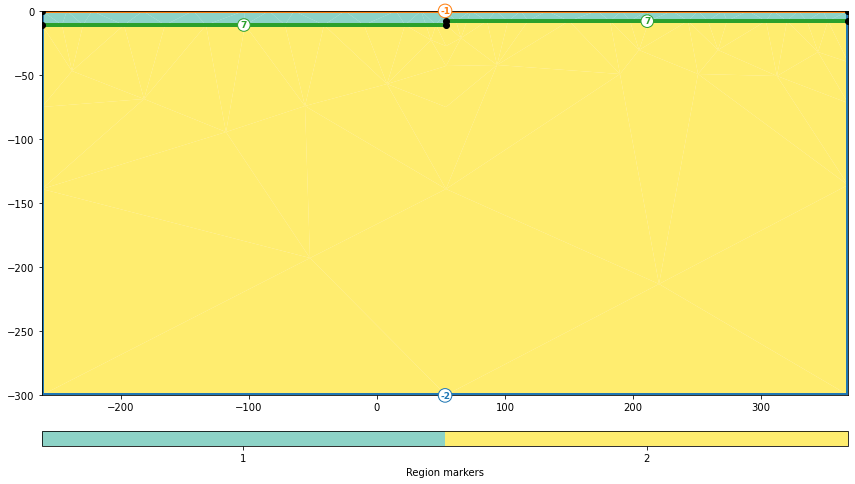

In [24]:
plc = mt.mergePLC([left, right])
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(plc, markers= True, ax=ax)
plc

Mesh: Nodes: 25 Cells: 0 Boundaries: 33

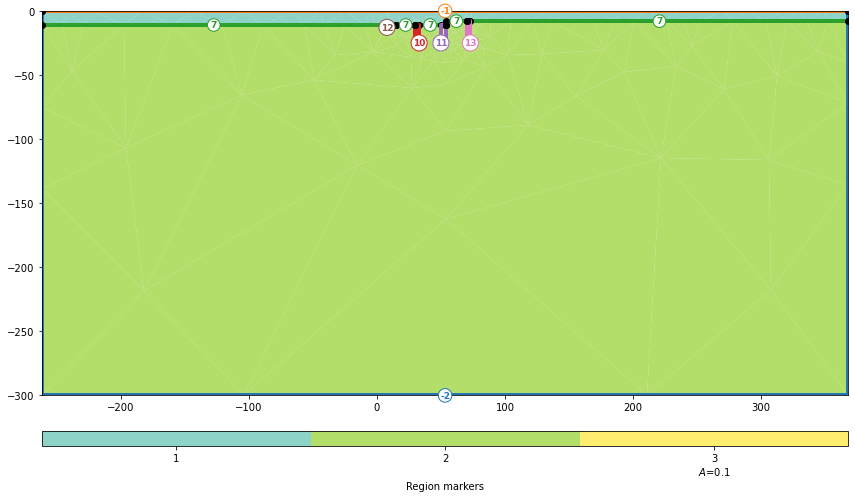

In [25]:
anomalie = mt.createRectangle(start=[30, -11], end=[33, -25], marker=3, area=0.1, boundaryMarker=10)
anomalie2 = mt.createRectangle(start=[50, -11], end=[54, -25], marker=3, area=0.1, boundaryMarker=11)
anomalie4 = mt.createPolygon([[15, -11], [11, -15], [9, -15], [7, -11]], isClosed=True, marker=3, area=0.1, boundaryMarker=12, interpolate='spline')
anomalie5 = mt.createRectangle(start=[70, -8], end=[73, -25], marker=3, area=0.1, boundaryMarker=13)
#anomalie6 = mt.createCircle(pos=[92,-22.5], radius=[3, 2], marker=4,
                        #boundaryMarker=14, area=0.1) #salle

plc += anomalie
plc += anomalie2
plc += anomalie4
plc += anomalie5
#plc += anomalie6
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(plc, markers= True, ax=ax)
plc

## Réseau d'électrodes

In [26]:
shmgeo = pg.load("aadip_dipsurf1.dat")

In [29]:
# shm = pg.load("aa15.dat")
shm = pg.load("aashm1.dat")
shm.add(pg.load("aadip_dipsurf1.dat"))
shm.add(pg.load("aa15.dat"))
# shm.add(pg.load("aa6.dat"))
# shm.add(pg.load("aa13.dat"))
# shm.add(pg.load("aa4sim.dat"))
# shm.add(pg.load("aa8.dat"))
# shm.add(pg.load("aa9.dat")) 
# shm.add(pg.load("aa4enterres.dat")) 
shm

Data: Sensors: 80 data: 3280, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

In [30]:
# shm = pg.load("aashl.dat")
# shm.remove(8*(shm['n']-shm['m']) < (shm['m']-shm['a']))
# shm

In [31]:
# shm.save('aashm1.dat')

In [32]:
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))

In [33]:
# shm = pg.load("aadip_dipsurf1.dat")
# plt.hist(shm['k'])
# np.count_nonzero(shm['k']<5000)

## Maillage

In [34]:
for s in shm.sensors():
    plc.createNode(s, marker=-99)
    plc.createNode(s - [0, 0.01])

plc #30 nodes + 18 * 2 (electrodes) = 66 nodes

Mesh: Nodes: 184 Cells: 0 Boundaries: 33

(<AxesSubplot:>, None)

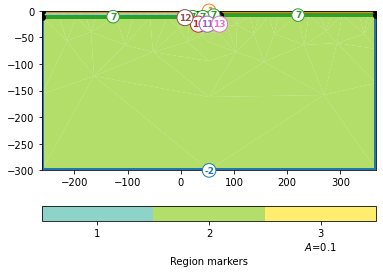

In [35]:
pg.show(plc, markers=True)

In [36]:
mesh = mt.createMesh(plc, quality=34)
# fig, ax = plt.subplots(figsize=(16, 8))
# pg.show(mesh, markers=True, showMesh=True,ax=ax)

## Rho effectives

In [37]:
rhomap = [ [1, 30],    #couverture
           [2, 1000],  #calcaire
           [3, 20]]    #fontis
           #[4, 50]]    #salle
# fig, ax = plt.subplots(figsize=(16, 8))
# pg.show(mesh, data=rhomap, label='Résistivités effectives [Ωm]', ax=ax,showMesh=True,logScale=True, xlabel='x [m]', ylabel='z [m]')#, cMap="tab10")
# ax.set_xlim(-5,111.5)
# ax.set_ylim(-30,0)
# plt.savefig('Tof/modelekarst2.pdf')

## Simulation

(<AxesSubplot:>, None)

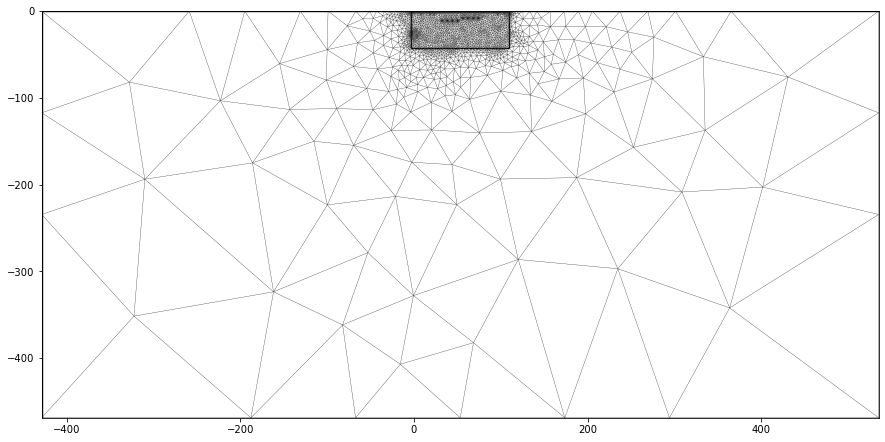

In [38]:
geo=pg.meshtools.createParaMeshPLC(shmgeo,paraMaxCellSize=4)
for p in shm.sensors():
    geo.createNode(p)
    geo.createNode(p - [0, 0.1])
mesh_invplc = pg.meshtools.createMesh(geo, quality=34)
fig, ax = plt.subplots(figsize=(15, 8))
pg.show(mesh_invplc, ax=ax, markers=False)
# ax.set_xlim(-5,111.5)
# ax.set_ylim(-50,0)

In [39]:
noiseAbs = 5e-5
noiseLevel = 0.03

In [40]:
hom = ert.simulate(mesh_invplc, res=1.0, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)

hom.save('homogeneous.ohm', 'a b m n u')

1

In [41]:
data = ert.simulate(mesh, res=rhomap, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)
#pg.show(mesh, notebook=True)

In [42]:
data['err'] = ert.estimateError(data, absoluteUError=noiseAbs, relativeError=noiseLevel) #50microV et 3%

In [43]:
noise = data('u')*data('err') * pg.randn(data.size(), seed=1337)

In [44]:
noise

3280 [-0.0670099955755413,...,0.0129982175247663]

In [45]:
data.set('u', data('u') + noise)

In [46]:
data.set('k', 1.0/ (hom('u') / hom('i')))
data.set('rhoa', data('k') * data('u') / data('i'))
# data['err'] = ert.estimateError(data, absoluteUError=5e-5, relativeError=0.03) #50microV et 3%

data.save('simulated.dat', 'a b m n rhoa k u i err')

# np.testing.assert_approx_equal(het('rhoa')[0], 9.5, 1)

1

In [47]:
data['err']

3280 [0.03001574891443535,...,0.0302530719453453]

In [48]:
pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

14/06/22 - 03:14:34 - pyGIMLi - INFO - 1.8265585642781959 4553.7997647938655
14/06/22 - 03:14:34 - pyGIMLi - INFO - Simulated data Data: Sensors: 80 data: 3280, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']
14/06/22 - 03:14:34 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
14/06/22 - 03:14:34 - pyGIMLi - INFO - Simulated rhoa (min/max) -2815.6455556300016 780.2597883599717
14/06/22 - 03:14:34 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0015618146970353 7.383446474566268


In [49]:
a=np.count_nonzero(data['rhoa'])
a

3280

In [50]:
pg.info('rhoa<0', 100*(np.count_nonzero(data['rhoa']<0)/a))
pg.info('err>5', 100*(np.count_nonzero(data['err']>0.05)/a))
pg.info('k>5000', 100*(np.count_nonzero(abs(data['k'])>5000)/a))

14/06/22 - 03:14:34 - pyGIMLi - INFO - rhoa<0 1.4329268292682928
14/06/22 - 03:14:34 - pyGIMLi - INFO - err>5 0.09146341463414635
14/06/22 - 03:14:34 - pyGIMLi - INFO - k>5000 9.481707317073171


In [51]:
# shm = pg.load("aashl.dat")
# shm.remove(8*(shm['n']-shm['m']) < (shm['m']-shm['a']))
# shm

In [52]:
# shm.save('aashm1.dat')

In [53]:
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))

In [54]:
# shm = pg.load("aadip_dipsurf1.dat")
# plt.hist(shm['k'])
# np.count_nonzero(shm['k']<10000)

In [55]:
# shm = pg.load("aashl.dat")
# shm.remove(8*(shm['n']-shm['m']) < (shm['m']-shm['a']))
# shm

In [56]:
# shm.save('aashm1.dat')

In [57]:
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))

In [58]:
# shm = pg.load("aadip_dipsurf1.dat")
# plt.hist(shm['k'])
# np.count_nonzero(shm['k']<10000)

In [59]:
# shm = pg.load("aashl.dat")
# shm.remove(8*(shm['n']-shm['m']) < (shm['m']-shm['a']))
# shm

In [60]:
# shm.save('aashm1.dat')

In [61]:
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))

In [62]:
# shm = pg.load("aadip_dipsurf1.dat")
# plt.hist(shm['k'])
# np.count_nonzero(shm['k']<10000)

In [63]:
# np.median(data['rhoa']), np.mean(data['rhoa'])

Data: Sensors: 80 data: 3280, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

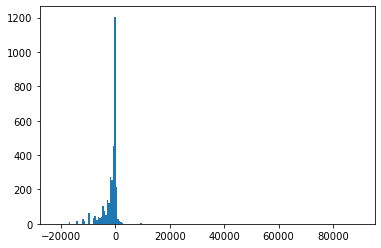

In [64]:
plt.hist(data['k'], bins=200)
data

In [65]:
max(data['k'])

89593.58576067406

In [66]:
# data.remove(abs(data['k'])>10000)
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))
# plt.hist(data['k'], bins=200)
# pg.info('Simulated data', data)
# pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
# pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)
# data.save('aadip_dipsurf1.dat')

In [67]:
# data.remove(data['rhoa']<0)
# data.remove(data['rhoa']>20)
# plt.hist(data['rhoa'], bins=100);

In [68]:
# plt.hist(data['u'], bins=100);

In [69]:
data.remove(abs(data['k'])>5000)
data.remove(data['rhoa'] < 2)
data.remove(data['rhoa'] > 2000)
data.remove(data['err'] > 0.05)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa'])) #si rhoa <0
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

data.save('simulated.dat')
data

14/06/22 - 03:15:21 - pyGIMLi - INFO - Filtered rhoa (min/max) 15.586857911224342 418.1474824866638
14/06/22 - 03:15:21 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0015618146970353 3.8419188258991657


Data: Sensors: 80 data: 3154, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

In [70]:
pg.info('filtré', (100*(a-np.count_nonzero(data['rhoa']))/a))

14/06/22 - 03:15:24 - pyGIMLi - INFO - filtré 3.841463414634146


In [71]:
# data.remove(abs(data['k'])>10000)
# plt.hist(data['k'], bins=200)
# data

In [72]:
# data.remove(abs(data['k'])>5000)
# plt.hist(data['k'], bins=200)
# data

In [73]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ert.show(data, ax=ax)

In [74]:
# ert.show(data, data['err']*100)

## Inversion

In [75]:
pos = {i+1 : np.array(shm.sensorPosition(i)) for i in range(shm.sensorCount())}
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}

In [76]:
# median=np.mean(data('rhoa'))
# mA0=median*5
# mB0=0.2
# # experience = {'inverted_model': median, 'mA0': mA0, 'mB0': mB0}
# experience = {'mA0tout1': mA0, 'mB0tout1': mB0}
# mA0, mB0

In [77]:
# mgr = ert.ERTManager('simulated.dat')
# for name,  startmodel in experience.items():
#     inv = mgr.invert(data = data, mesh=mesh_invplc, lam=100, verbose=True, startModel=startmodel)
#     mgr.saveResult(name)

In [78]:
mgr = ert.ERTManager('simulated.dat')
inv = mgr.invert(data = data, mesh=mesh_invplc, lam=50, verbose=True, zWeight=0.5)

14/06/22 - 03:15:44 - pyGIMLi - INFO - Found 2 regions.
14/06/22 - 03:15:44 - pyGIMLi - INFO - Region with smallest marker (1) set to background
14/06/22 - 03:15:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
14/06/22 - 03:15:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
14/06/22 - 03:15:45 - pyGIMLi - INFO - Use median(data values)=33.87251860868636
14/06/22 - 03:15:45 - pyGIMLi - INFO - Created startmodel from forward operator: 6213 [33.87251860868636,...,33.87251860868636]
14/06/22 - 03:15:45 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001C190E53360>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001C190E539A0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001C194573580>
min/max (data): 15.59/418
min/max (error): 3%/3.84%
min/max (start model): 33.87/33.87
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 70.42 (dPhi = 41.52%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 50.98 (dPhi = 27.1%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 16.86 (dPhi = 65.83%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 9.11 (dPhi = 45.84%) lam: 50.0
--------------------------------

In [80]:
# loadmesh = pg.load('ENTjust/ERTManager/resistivity-pd.bms')
# modelP = pg.load('ENTjust/ERTManager/resistivity.vector')
# coverage = pg.load('ENTjust/ERTManager/resistivity-cov.vector')

In [81]:
modelP = mgr.paraModel(inv)  # do the mapping
loadmesh = mgr.paraDomain

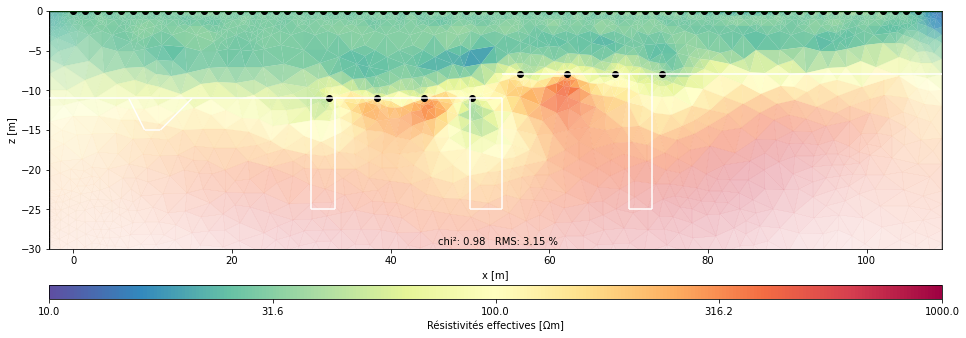

In [83]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin =10, cMax=1000, coverage=mgr.coverage())
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')
ax.set_ylim(-30,0)
plt.savefig('FINAL/15.pdf', bbox_inches='tight', pad_inches=0.05)

In [114]:
# parameters = {'axes.labelsize': 10}
# plt.rcParams.update(parameters)

(-30.0, 0.0)

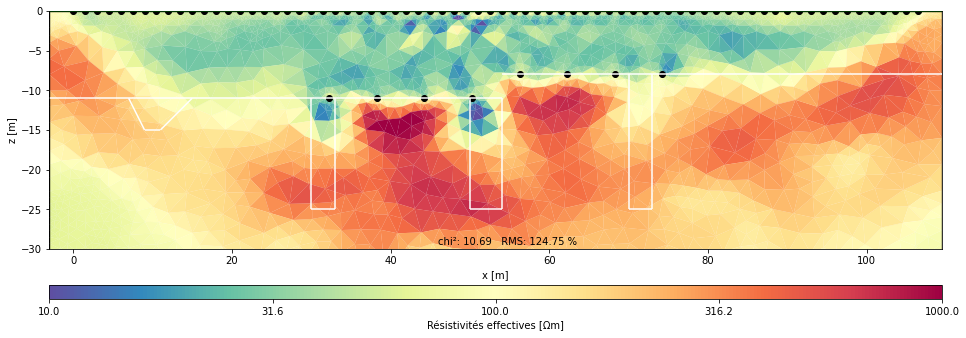

In [119]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin =10, cMax=1000)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')
ax.set_ylim(-30,0)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin =10, cMax=1000)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')

05/06/22 - 18:10:05 - pyGIMLi - INFO - Saving resistivity data to: ENTjust\ERTManager


Path ENTjust\ERTManager already exists. Skipping


('ENTjust\\ERTManager', <Figure size 1152x720 with 2 Axes>, <AxesSubplot:>)

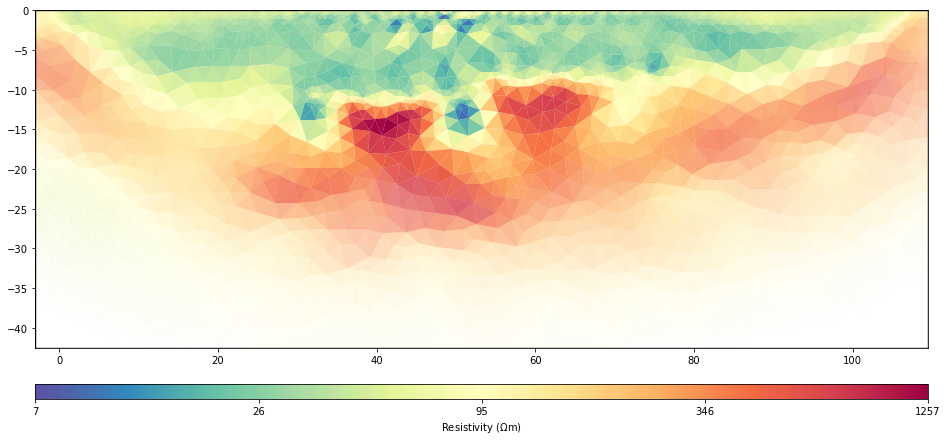

In [86]:
mgr.saveResult('ENTjust')

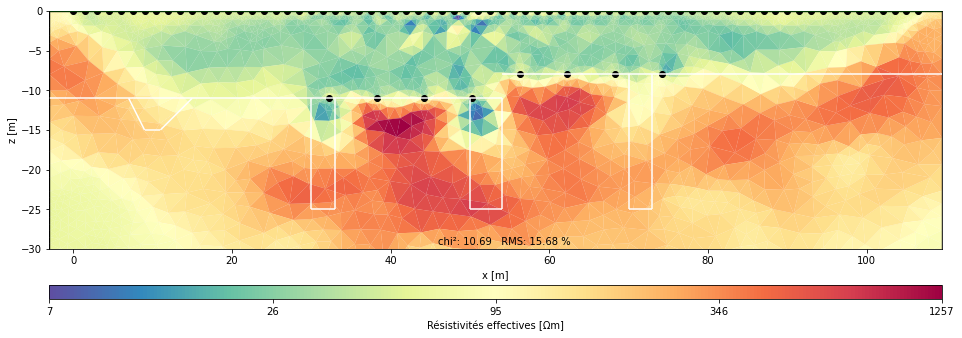

In [120]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')
ax.set_ylim(-30,0)
plt.savefig('tof04_06/ent draw.pdf')

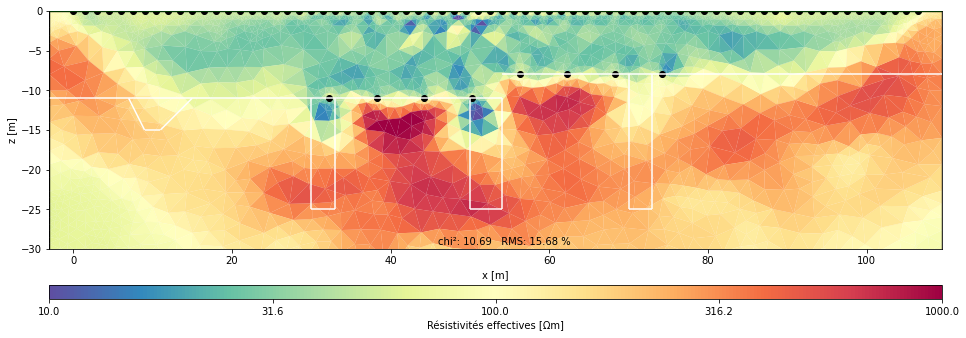

In [121]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin =10, cMax=1000)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='w')  #data.remove(data['rhoa'] < 20) data.remove(data['err'] > 0.02)
ax.set_ylim(-30,0)
plt.savefig('tof04_06/ent draw max.pdf')

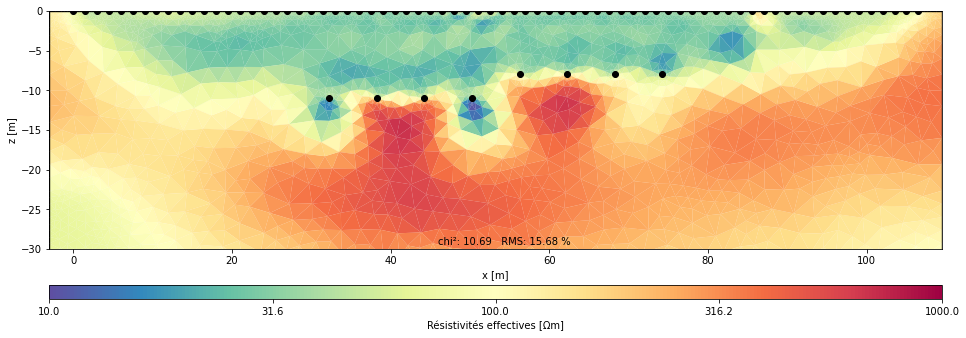

In [122]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
mgr.showResult(cMin =10, cMax=1000, logScale=True, ax=ax, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
ax.set_ylim(-30,0)
plt.savefig('tof04_06/ent vierge max.pdf')

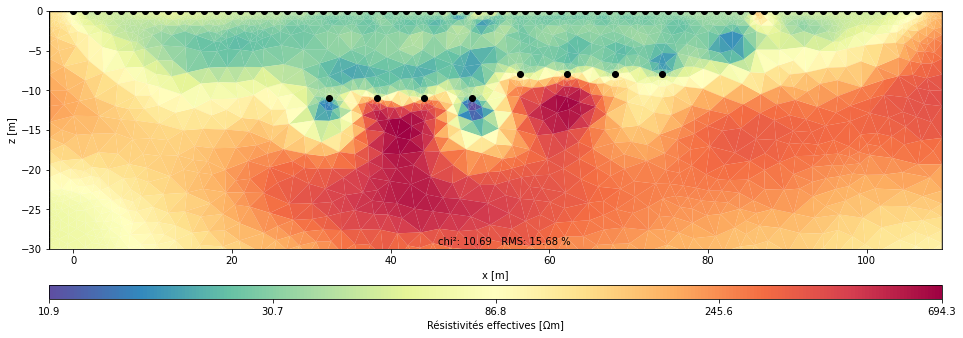

In [123]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
mgr.showResult(ax=ax, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
ax.set_ylim(-30,0)
plt.savefig('tof04_06/ent vierge.pdf')

In [64]:
print( f'chi²: {round(mgr.inv.chi2(),2)}')
print( f'RMS: {round(mgr.inv.relrms(),2)}')

chi²: 20.39
RMS: 306.42


In [ ]:
# mgr.showFit()
# plt.savefig('Tof/showFit 6.pdf')

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))
# mgr.showMisfit(ax=ax, label='Relative misfit (%)')
# # plt.savefig('Tof/misfit ddslm.pdf')

## DOI

#### Surface

In [124]:
pos = {i+1 : np.array(shmgeo.sensorPosition(i)) for i in range(shmgeo.sensorCount())}
R = []
mAxz = pg.load('mA0/ERTManager/resistivity.vector') #surf
mBxz = pg.load('mB0/ERTManager/resistivity.vector') #surf
mesh_doi = pg.load('mA0/ERTManager/resistivity-pd.bms') #surf

In [126]:
mesh_doi

Mesh: Nodes: 3209 Cells: 5749 Boundaries: 8957
Mesh contains data: Coverage, Resistivity, Resistivity (log10), S_Coverage

In [127]:
R = (mAxz - mBxz)/(mA0-mB0)

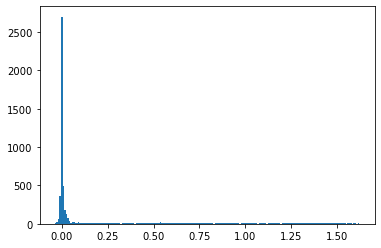

In [128]:
plt.hist(R, bins=200);

In [129]:
R

5749 [0.00318827630136894,...,1.4968757808844602]

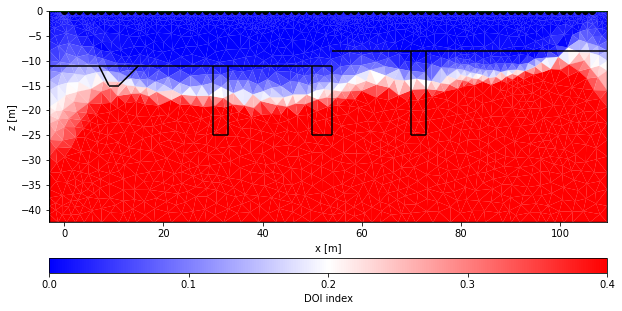

In [138]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, abs(R), ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index', cMin=0, cMax=0.4)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='k')
# ax.set_ylim(-30,0)
plt.savefig('tof04_06/surf.pdf')

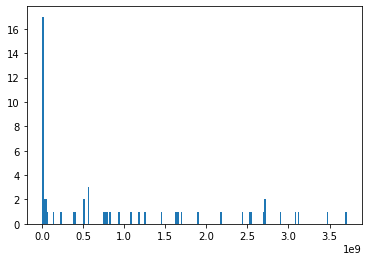

In [136]:
plt.hist(np.exp(mAxz[mAxz<np.percentile(mAxz,0.99)]),bins=200);

In [ ]:
mAxz - mBxz

In [ ]:
np.percentile(R,0.9)

In [ ]:
Rl=R[R>np.percentile(R,0.1)]
Rlh= Rl[Rl<np.percentile(R,0.90)]

In [ ]:
plt.hist(R, bins=200);

#### ENTERREE

In [ ]:
#ENT
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
R = []
mAxz = pg.load('mA0tout1/ERTManager/resistivity.vector') #ENT
mBxz = pg.load('mB0tout1/ERTManager/resistivity.vector') #ENT
mesh_doi = pg.load('mA0tout1/ERTManager/resistivity-pd.bms') #ENT

In [ ]:
mA0

In [ ]:
R = (mAxz - mBxz)/(mA0-mB0)

In [ ]:
plt.hist(R, bins=200);

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, abs(R), ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index', cMin=0, cMax=0.2)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='k')
# ax.set_ylim(-30,0)
# plt.savefig('tof04_06/DOIENT1.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, abs(R), ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index', cMin=0, cMax=0.15)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='k')
# ax.set_ylim(-30,0)
plt.savefig('tof04_06/DOIENT11.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8),nrows=2)
# ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, mAxz, ax=ax[0], cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index SURF', cMin=0, cMax=100)
pg.show(mesh_doi, mBxz, ax=ax[1], cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index SURF', cMin=0, cMax=100)
# pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
#                                  linewidth=0.1, color='k')

In [ ]:
plt.hist(R, bins=200)
R

## Sensibilité

In [ ]:
for cell in mesh.cells():
    cell.setMarker(999)
inv_mesh = appendTriangleBoundary(mesh, quality=31, smooth=True,
                              marker=99, isSubSurface=True)

pg.show(inv_mesh, markers=True, showMesh=True)

In [ ]:
fop = ERTModelling()
fop.setData(data)
fop.setMesh(inv_mesh)

model = np.ones(mesh.cellCount())
fop.createJacobian(model)

In [ ]:
def getABMN(scheme, idx):
    """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
    `scheme`."""
    coords = {}
    for elec in "abmn":
        elec_id = int(scheme(elec)[idx])
        elec_pos = scheme.sensorPosition(elec_id)
        coords[elec] = elec_pos.x(), elec_pos.y()
    return coords

In [ ]:
def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "red"
        else:
            color = "blue"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="right", va='top', bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), xytext=(0, 20),
                    textcoords='offset points', arrowprops=dict(arrowstyle="wedge, tail_width=.5", fc=color, ec=color, patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

In [ ]:
fig, ax = plt.subplots()
plotABMN(ax, data, 0)

In [ ]:
sensitivity = [(i[0], np.array(i[1])) for i in enumerate(fop.jacobian())]

In [ ]:
max_max = np.max(np.abs(np.array([sensitivity[i][1] for i in range(len(sensitivity))])))
max_max

In [ ]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}

In [ ]:
# normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
# np.max(normsens)

In [ ]:
i = 348 # look at the sensitivity of one array commence à 0 !!
fig, ax = plt.subplots(figsize=(30, 15))
#
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
# Electrode annotations
plotABMN(ax, data, i)

# Log-scaled and normalized sensitivity
# normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
# normsens /= max_max
# pg.show(mesh, normsens, cMap="RdGy_r", ax=ax, orientation="vertical",
#          label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)
# ax.set_ylim(-25, 0)

#sensitivity
normsens = 100*pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
pg.show(mesh, normsens, cMap="jet", ax=ax, orientation="vertical",
             label="Sensitivity x 100")
ax.set_ylim(-25, 0)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

totsens = pg.core.RVector(np.zeros(mesh.cellCount()))

for i in sensitivity:

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(i[1]/mesh.cellSizes(), 8e-4)
    totsens += np.abs(normsens)
totsens /= np.max(np.abs(totsens))
pg.show(mesh, totsens, cMap="hot_r", ax=ax, orientation="horizontal",
        label="Normalized\nabsolute sensitivity", nLevs=3, cMin=0, cMax=1)
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')

from matplotlib import animation
from IPython.display import HTML
def animate(i):
    ax.clear()
    ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
    # Electrode annotations
    plotABMN(ax, data, i)

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
    normsens /= np.max(np.abs(normsens))
    pg.show(mesh, normsens, cMap="RdGy_r", ax=ax, orientation="vertical",
            label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)
    ax.text(-4,-1,f'array: {i:d}')

fig, ax = plt.subplots(figsize = (10,8))
anim = animation.FuncAnimation(fig, animate,
                               frames=len(sensitivity), interval=500, 
                               blit=False)
anim.save('./sensibilite_sequence.mp4')